In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

### Load Dataset

In [2]:
events = pd.read_json("../data/events.log", 
                      lines=True,
                      dtype={"product_id": "int64"})

### Transform Dataset

In [3]:
events = events.rename(columns={"session": "session_id"})
events["search_id"] = (events["name"] == "search").cumsum()

query_columns = ["session_id", "search_id", "query"]
queries = events.loc[events["name"] == "search", query_columns]

view_columns = ["session_id", "search_id", "title", "product_id", "category"]
views = events.loc[events["name"] == "productview", view_columns]

data = pd.merge(queries, views, on=["session_id", "search_id"], how="left")
data.head(10)

session_id  search_id  \
0  b9705ccb2af11a0ed9201a7505520b946047caa4a7ffea...          1   
1  d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...          2   
2  d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...          2   
3  d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...          2   
4  d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...          3   
5  d29564e113c3b8eeca1570ec26845be5adb73d57e40b65...          3   
6  04887a80950be6087da8b1e0ec3b80e8478db27779ce42...          4   
7  04887a80950be6087da8b1e0ec3b80e8478db27779ce42...          5   
8  e4869d990ffcedef6e114cbe49664e839af1df8c2181fa...          6   
9  56b9b97509d497a01c8be6cf0aaf3c53680b7e62bb112b...          7   

                        query                          title  product_id  \
0                  blue dress                            NaN         NaN   
1           louis vuitton bag                white prada bag   2089482.0   
2           louis vuitton bag              white leather bag   3909061.0   
3           louis vuitton bag                    leather bag   6747521.0   
4           blue metalic coat                 red gucci coat   7366850.0   
5           blue metalic coat                           coat   1255264.0   
6             ana luisa watch  beige metalic ana luisa watch   8882812.0   
7     gold calvin klein dress                            NaN         NaN   
8  wool louis vuitton handbag                            NaN         NaN   
9            gold casio watch       green leather wristwatch   6656681.0   

    category  
0        NaN  
1       bags  
2       bags  
3       bags  
4      coats  
5      coats  
6  jewellery  
7        NaN  
8        NaN  
9    watches

### EDA

**Number of categories per one search**

In [4]:
n_categories = data.groupby("search_id")["category"].nunique()
n_multicateg_searches = (n_categories > 1).sum()

print(f"Number of searches that got multiple categories: {n_multicateg_searches}")

Number of searches that got multiple categories: 0


Number of searches that got multiple categories is equal to 0. This, in this case I would assume that each search corresponds with only one category. However, in reality this is not always true.

**Number of product views per search**

<Figure size 576x432 with 0 Axes>

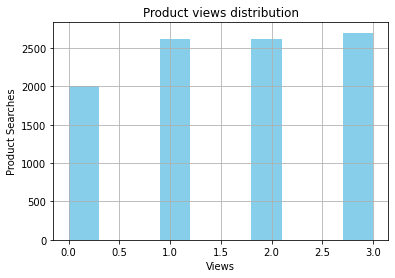

<Figure size 576x432 with 0 Axes>

In [5]:
s = data.groupby("search_id").agg({'product_id': lambda x: x.notnull().sum()})

plt.hist(s, bins=10, color='skyblue')

plt.title('Product views distribution')
plt.xlabel('Views')
plt.ylabel('Product Searches')
plt.grid(True)
plt.figure(figsize=(8, 6))  # Adjust the size as per your preference

Data in this dataset looks quite artificial to me. Almost even distribution of views across 1, 2 and 3 views. Again in real life I would expect to see exponential-like distribution.

**Typos in searches**

In [6]:
from functools import reduce
from collections import Counter

s = reduce(lambda x, y: x + " " + y, queries["query"].values).split(" ")
print(f"Searches in the dataset: {len(queries)}")
print(f"Unique searches in the dataset: {queries['query'].nunique()}")
print(f"Unique words in all query searches: {len(set(s))}")
print()

s = (pd.DataFrame
 .from_dict(dict(Counter(s)), orient="index", columns=["frequency"])
 .sort_values("frequency", ascending=False)
)

with pd.option_context('display.max_rows',10):
    print(s)

Searches in the dataset: 9949
Unique searches in the dataset: 2150
Unique words in all query searches: 45

         frequency
metalic       1487
watch         1462
gold          1432
leather       1395
wool          1389
...            ...
Rolex          317
north          317
face           317
new            275
balance        275

[45 rows x 1 columns]


The amount of unique words in searches is very low, only 45 unique words. My bet is that BoW + Simple Classifier would be the best approach.

**Categories statistics**

In [7]:
data.value_counts("category")

category
pants        2385
coats        2352
watches      2334
dresses      2287
shoes        2246
jewellery    2217
bags         2139
dtype: int64

Data points are distributed more or less uniformly among categories. No class balance techniques are needed. Accuracy can be used as a metric

### Baseline

In [8]:
categories = {"pants": "pants", 
              "coats": "coat", 
              "watches": "watch", 
              "dresses": "dress", 
              "shoes": "shoes", 
              "jewellery": "jewellery", 
              "bags": "bag"}

for cat, cat_norm in categories.items():
    data["label"] = data["query"].apply(lambda x: cat_norm in x)
    
    recall = data.loc[data["category"] == cat, "label"].mean()
    precision = (data.loc[data["label"], "category"] == cat).mean()
    
    print(cat, round(recall, 3), round(precision, 3))

pants 0.319 0.897
coats 0.527 0.902
watches 1.0 0.455
dresses 0.474 0.893
shoes 0.292 0.908
jewellery 0.0 nan
bags 1.0 0.879


### BoW + Simple Classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

dataset = pd.merge(queries,
                   views.groupby("search_id", as_index=False)["category"].first(),
                   on="search_id")

# Split data
train, test = train_test_split(dataset, test_size=0.25)
X_train, y_train = train["query"].values, train["category"].values
X_test, y_test = test["query"].values, test["category"].values

# Define artefacts
bow = CountVectorizer(ngram_range=(1, 2))
scaler = StandardScaler()
lr = LogisticRegression(multi_class='ovr')

# Compute bag of words
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

print("Confusion matrix:")
confusion_matrix(y_test, y_test_pred)

Accuracy: 0.9345088161209067
Confusion matrix:


array([[281,   0,   0,   0,   0,   0,   0],
       [  0, 297,   0,   0,   0,   0,   0],
       [  0,   0, 269,   0,   0,   0,   0],
       [  0,   0,   0, 223,   0,   0,  21],
       [  0,   0,   0,   0, 305,   0,   0],
       [  0,   0,   0,   0,   0, 279,   0],
       [  0,   0,   0, 109,   0,   0, 201]])

From confusion matrix it is clear, that all categories are predicted perfectly, except for two that are often confused. Let's look at them more precisely.

In [11]:
test[y_test != y_test_pred].head(15)

session_id  search_id  \
6364  e168700139afdc8a8780291aa26454824c503ea9506fef...       7986   
3416  c8187edc853c46332ea526016466a897385c5209b9b2c2...       4311   
7898  902ec6fdf33ef86f12c4c46204b7d8d619006c253308d9...       9895   
6671  d0c853e68f4336fb0636dea6a5dec7dba9659a0e2e05c1...       8380   
1254  830ee4511954ec928514890ed84a1098d686a22a1fcf49...       1594   
2331  6aa0e18c6730d88711ae35675b7a935c04afd9964f58de...       2961   
2967  a300e764e0c9e77ae0a0809b8183e03d44dbb07063fc70...       3743   
5338  a14444e750b1d8d3f8990c5142b493729c717203ad8e2d...       6687   
2495  0fbdb35922b5595c182dc0fead06b63417d8e1989134a6...       3155   
6893  90baf6e19807b4fb8d28d8dba5f7da1cb2645a91de117a...       8645   
2154  e4032294a2ecb4c69318b902c65c71ff51f55727be1ee2...       2729   
3256  bc4c13feebc83062734a697d5fe1233415af3272defadf...       4113   
6067  a1ba2174f14bb3ca56756ed69fcdff52fec8df69365126...       7601   
7438  0b433b5f315ab6bc2cc073f3c45babcecd1c299b6411d9...       9327   
7426  bbfc513de52ccac32dae8a7d71ad7809df2a75f8c5cd69...       9313   

                     query   category  
6364           green watch  jewellery  
3416       gold wristwatch    watches  
7898      green wool watch    watches  
6671                 watch    watches  
1254   red wool wristwatch    watches  
2331            wristwatch    watches  
2967            wristwatch    watches  
5338  blue wool wristwatch  jewellery  
2495            blue watch  jewellery  
6893            wool watch    watches  
2154      white wristwatch    watches  
3256        red gold watch  jewellery  
6067          yellow watch  jewellery  
7438            wristwatch    watches  
7426      green wristwatch    watches

Now let's check if it's possible, so that similar query got different categories in different search sessions.

In [12]:
df = train.groupby("query", as_index=False)["category"].nunique()
df[df["category"] > 1].head(10)

query  category
81        beige gold watch         2
82   beige gold wristwatch         2
133    beige leather watch         2
166    beige metalic watch         2
182            beige watch         2
215       beige wool watch         2
217       beige wristwatch         2
281       black gold watch         2
282  black gold wristwatch         2
335    black leather watch         2

### BoW + Classifier + Transformed labels

From the preious example, it's obvious, that the only problem of BoW + Classifier approach is that some identical queries may have different category labels in different sessions. More precisely, this confusion happens only between two labels: jewellery and watch. Let's adjust the task, including one more category = 'watch & jewellery' for those queries that have two labels in train.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

dataset = pd.merge(queries,
                   views.groupby("search_id", as_index=False)["category"].first(),
                   on="search_id")

# Split data
train_idx, test_idx = train_test_split(dataset.index, test_size=0.25)

X_train = dataset.filter(items=train_idx, axis=0)["query"].values
y_train = dataset.filter(items=train_idx, axis=0).groupby("query")["category"].transform(lambda x: " & ".join((set(x)))).values

X_test = dataset.filter(items=test_idx, axis=0)["query"].values
y_test = dataset.groupby("query")["category"].transform(lambda x: " & ".join((set(x)))).filter(items=test_idx)

# Define artefacts
bow = CountVectorizer(ngram_range=(1, 1))
lr = LogisticRegression(multi_class='ovr')

# Compute bag of words
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")

print("Confusion matrix:")
confusion_matrix(y_test, y_test_pred)

Accuracy: 0.9984886649874055
Confusion matrix:


array([[265,   0,   0,   0,   0,   0,   0,   0],
       [  0, 307,   0,   0,   0,   0,   0,   0],
       [  0,   0, 307,   0,   0,   0,   0,   0],
       [  0,   0,   0, 149,   0,   0,   0,   3],
       [  0,   0,   0,   0, 274,   0,   0,   0],
       [  0,   0,   0,   0,   0, 268,   0,   0],
       [  0,   0,   0,   0,   0,   0, 164,   0],
       [  0,   0,   0,   0,   0,   0,   0, 248]])

In [15]:
dataset.filter(items=test_idx, axis=0)[y_test != y_test_pred].head(15)

session_id  search_id  \
2718  db62c828d7035f2ee1cc04abd22b4277d1f40fb6ac52e9...       3437   
97    2f6062b5f96322354cd5b1d83ba7622d9e3c9c84804b91...        127   
3182  8e442eaa3cb1373af4de0dbbf30c233d4ff930087626e2...       4014   

                         query   category  
2718  black metalic wristwatch  jewellery  
97           red metalic watch  jewellery  
3182       green metalic watch  jewellery

Looks way better. LGTM!